# Accelerated Alternating Projection

Paper: https://arxiv.org/pdf/1711.05519.pdf

Matlab Script: https://github.com/caesarcai/AccAltProj_for_RPCA/blob/master/AccAltProj.m

Full Repository: https://github.com/caesarcai/AccAltProj_for_RPCA 

In [1]:
import numpy as np
from numpy import linalg as LA
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
import math
import scipy.stats as stats

from helper import *

torch.set_printoptions(precision=3, sci_mode=True)

## Unrolled version

In [2]:
## ======================== Learned AccAltProj model ========================
## recover low-rank matrix L from M = L + S

class InitStage(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, M0, r):
        m, n = M0.shape
        norm_of_M0 = torch.linalg.norm(M0)
        beta = 1/(2 * np.power(m * n, 1/4))
        beta_init = 4 * beta
        zeta = beta_init * torch.linalg.norm(M0, 2)
        S = thres(M0, zeta, hard=True, old=False)
        U, Sigma, V = torch.linalg.svd(M0 - S, full_matrices=False)
        U, Sigma, V = U[:,:r], Sigma[:r], V.t()[:, :r]
        L = U @ torch.diag(Sigma) @ V.t()
        zeta = beta * Sigma[0]
        S = M0 - L
        S = thres(S, zeta, hard=True, old=False)
        return S, L, U, V, norm_of_M0

class ProjStage(nn.Module):
    def __init__(self, gamma, lay):
        super().__init__()
        self.gamma = gamma
        self.lay = lay
    def forward(self, M0, S, U, V, r, beta):
        ## Update L
        Z = M0 - S
        Q1, R1 = torch.linalg.qr(Z.t() @ U - V @ ((Z @ V).t() @ U)) ## reduced QR
        Q2, R2 = torch.linalg.qr(Z @ V - U @ (U.t() @ Z @ V)) ## reduced QR
        A = torch.cat((torch.cat((U.t() @ Z @ V, R1.t()), 1), 
                        torch.cat((R2, torch.zeros(R2.shape)), 1)), 0) ## A is 2r x 2r matrix
        Um, Sm, Vm = torch.linalg.svd(A, full_matrices=False)
        U = torch.cat((U, Q2), 1) @ Um[:,:r]
        V = torch.cat((V, Q1), 1) @ Vm.t()[:,:r]
        L = U @ torch.diag(Sm[:r]) @ V.t()
        ## Update S
        zeta = beta * (Sm[r] + torch.pow(self.gamma, self.lay) * Sm[0])
        S = M0 - L
        S = thres(S, zeta, hard=True, old=False)
        return S, L, U, V

class LearnedAAP(nn.Module):
    def __init__(self, max_iter, d1, d2):
        super().__init__()
        self.max_iter = max_iter
        self.gamma = nn.Parameter(torch.tensor(0.7))
        self.beta = nn.Parameter(torch.tensor(1/(2 * np.power(d1 * d2, 1/4))))

        ## Stack layers
        self.layer = [InitStage()]
        for t in range(max_iter):
            self.layer.append(ProjStage(self.gamma, t+1))
        self.layers = nn.Sequential(*self.layer)
        ## Track loss
        self.err = np.zeros(max_iter + 1)

    def forward(self, M0, r):
        lay_init = self.layers[0]
        S, L, U, V, norm_of_M0 = lay_init(M0, r)
        for t in range(1, self.max_iter + 1):
            lay = self.layers[t]
            S, L, U, V = lay(M0, S, U, V, r, self.beta)
            self.err[t] = torch.linalg.norm(M0 - L - S)/ norm_of_M0
        return L, S

## The Pipeline

### Scenario 1:
**alpha = 0.1** (low sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=7.579e-01; beta=7.070e-02

***results: only relative err increased (from 0 to <5e-07 which is also very good) whereas the other errors got reduced***

In [3]:
## ======================== 0. set constants ========================
d1 = 250                   # num. of rows
d2 = 250                   # num. of columns
max_iter = 50              # num. of layers trained
alpha_true = 0.1
c_true = 1
r = 2
dataset_size = 300

## ======================== 1. generate data ========================
train, test =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [4]:
## ======================== 2. estimations by classical ========================
## ======================== USING IRCUR AS EST ========================
train_est = []
for i, (L_true, S_true, M_true) in enumerate(train):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est.append((L0, S0, M_true))

In [5]:
## ======================== 3. train unrolled network with estimated data ========================
net, params_bftrain, params_aftrain, l0_norm_of_S_Shat = train_nn(LearnedAAP(max_iter, d1, d2), r \
                                                                    , lr=2e-02, weight_decay=0 \
                                                                    , nepochs=8, dataset=train_est)

[Parameter containing:
tensor(7.028e-01, requires_grad=True), Parameter containing:
tensor(3.306e-02, dtype=torch.float64, requires_grad=True)]
tensor(-1.596e-09) tensor(-7.723e-10, dtype=torch.float64)
Epoch 1/8 at cost=1.032844032522462e-09
[Parameter containing:
tensor(7.036e-01, requires_grad=True), Parameter containing:
tensor(3.299e-02, dtype=torch.float64, requires_grad=True)]
tensor(5.517e-10) tensor(7.590e-10, dtype=torch.float64)
Epoch 1/8 at cost=6.41237549170448e-11
[Parameter containing:
tensor(7.044e-01, requires_grad=True), Parameter containing:
tensor(3.307e-02, dtype=torch.float64, requires_grad=True)]
tensor(-3.645e-10) tensor(-1.693e-10, dtype=torch.float64)
Epoch 1/8 at cost=2.99844288287332e-10
[Parameter containing:
tensor(7.056e-01, requires_grad=True), Parameter containing:
tensor(3.347e-02, dtype=torch.float64, requires_grad=True)]
tensor(-1.370e-09) tensor(-6.310e-10, dtype=torch.float64)
Epoch 1/8 at cost=1.1262038523973672e-10
[Parameter containing:
tensor(7

#### Evaluating unrolled network on train dataset

In [6]:
out_bftrain, out_hat = get_net_outputs(net, LearnedAAP(max_iter, d1, d2), r, train)
out_accaltproj = []
for i, (L_true, S_true, M_true) in enumerate(train):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj.append((L0, S0))

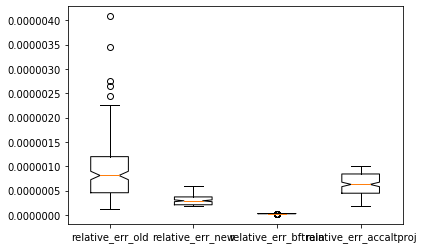

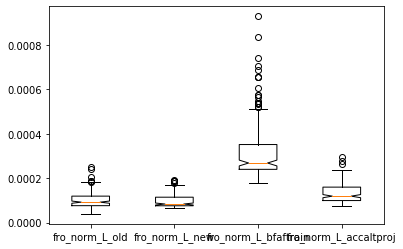

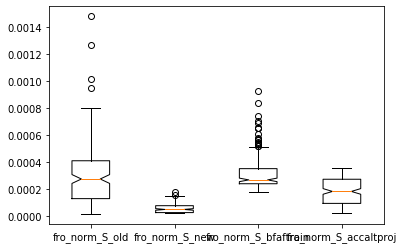

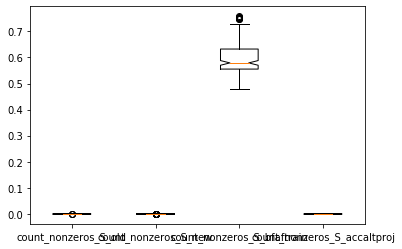

In [8]:
metrics = get_metrics(train, [x[:2] for x in train_est], out_bftrain, out_hat)
fro_norm_L_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train, out_accaltproj, out_bftrain, out_hat).values())[:4]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [10]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.1922318629789856e-27
fro_norm_L_new, fro_norm_L_old:  0.29989449594020673
fro_norm_S_new, fro_norm_S_old:  4.410958494974874e-30
count_nonzeros_S_new, count_nonzeros_S_old:  6.111701084492788e-32

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  2.4478423370434973e-43
fro_norm_L_new, fro_norm_L_accaltproj:  1.137787834997647e-18
fro_norm_S_new, fro_norm_S_accaltproj:  1.1283236406219878e-39
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  6.30131935159883e-34

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  1.0575463340011654e-54
fro_norm_S_new, fro_norm_S_bftrain:  7.229909890159509e-65
count_nonzeros_S_new, count_nonzeros_S_bftrain:  3.9213221843555734e-181


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/3710792896.py:4: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])


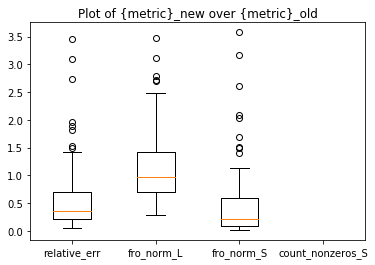

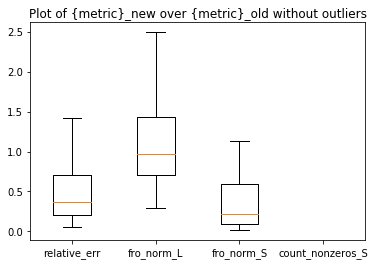

relative_err: 8/180 outliers
fro_norm_L: 5/180 outliers
fro_norm_S: 9/180 outliers
count_nonzeros_S: 0/180 outliers


In [11]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [12]:
print("P-values from test of mean with H1: _new/_old < 1")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  1.2000690930168604e-24
fro_norm_L:  0.9977078389644626
fro_norm_S:  4.225172002338109e-30
count_nonzeros_S:  nan


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/3711251554.py:4: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])


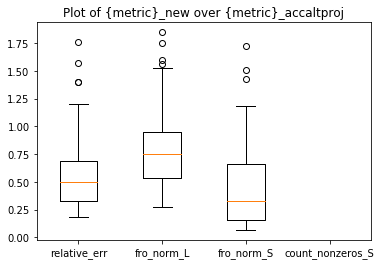

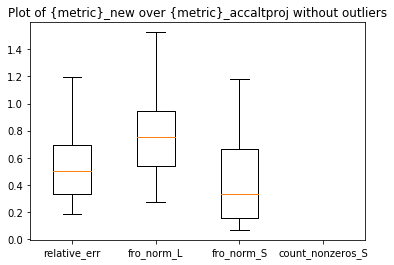

relative_err: 4/180 outliers
fro_norm_L: 4/180 outliers
fro_norm_S: 3/180 outliers
count_nonzeros_S: 0/180 outliers


In [13]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [14]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0324986412155336e-51
fro_norm_L:  1.3786844453547457e-16
fro_norm_S:  4.897123702154358e-53
count_nonzeros_S:  nan


In [15]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj))

0.0 1.18222215e-05
3.2e-05 2.7466669e-05


#### Evaluating unrolled network on test dataset

In [16]:
out_bftrain_ontest, out_hat_ontest = get_net_outputs(net, LearnedAAP(max_iter, d1, d2), r, test)
out_accaltproj_ontest = []
out_ircur_ontest = []
for (L_true, S_true, M_true) in test:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj_ontest.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    out_ircur_ontest.append((L0, S0))

/Users/elitanzc/Github/Unrolled_AccAltProj/helper.py:226: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/Unrolled_AccAltProj/helper.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


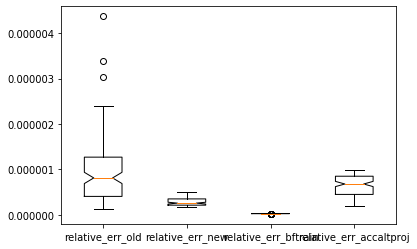

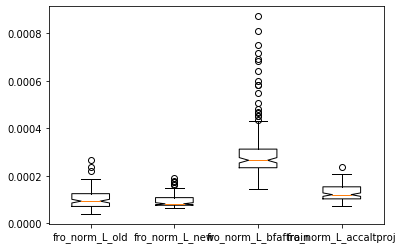

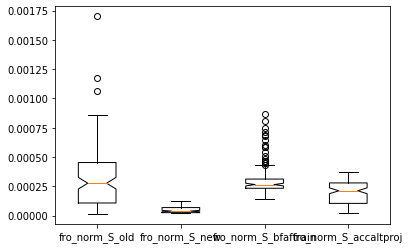

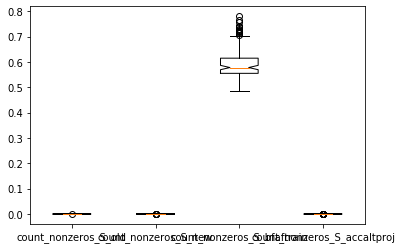

In [19]:
metrics = get_metrics(test, out_ircur_ontest, out_bftrain_ontest, out_hat_ontest)
fro_norm_L_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test, out_accaltproj_ontest, out_bftrain_ontest, out_hat_ontest).values())[:4]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
# plt.savefig('plots/p1.1.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
# plt.savefig('plots/p1.2.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
# plt.savefig('plots/p1.3.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
# plt.savefig('plots/p1.4.eps', format='eps')
plt.show()

In [20]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  4.048366487249967e-18
fro_norm_L_new, fro_norm_L_old:  0.07363117433052777
fro_norm_S_new, fro_norm_S_old:  4.863850437022388e-19
count_nonzeros_S_new, count_nonzeros_S_old:  5.782949095782901e-23

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  8.649305994325273e-34
fro_norm_L_new, fro_norm_L_accaltproj:  9.685402209386363e-15
fro_norm_S_new, fro_norm_S_accaltproj:  5.920570089270677e-30
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  4.2241819062480077e-26

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  4.596259324324075e-34
fro_norm_S_new, fro_norm_S_bftrain:  4.771073939380507e-41
count_nonzeros_S_new, count_nonzeros_S_bftrain:  2.0739604515454248e-119


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/2537990246.py:4: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])


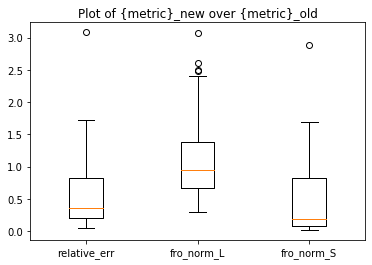

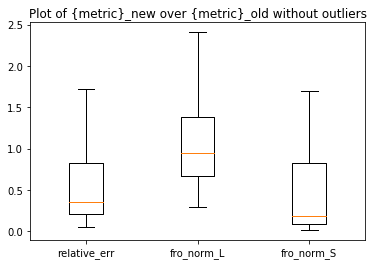

relative_err: 1/120 outliers
fro_norm_L: 4/120 outliers
fro_norm_S: 1/120 outliers


In [22]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err, \
     "fro_norm_L": fro_norm_L \
    , "fro_norm_S": fro_norm_S \
    #, "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
# plt.savefig('plots/p1.5.eps', format='eps')
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

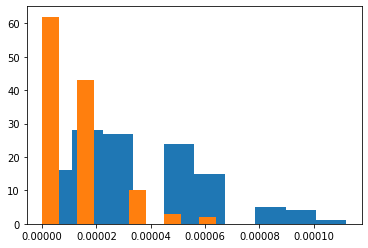

In [24]:
plt.hist(count_nonzeros_S_old)
plt.hist(count_nonzeros_S_new)
# plt.savefig('plots/p1.6.eps', format='eps')
plt.show()

In [25]:
print("P-values from test of mean with H1: _new/_old < 1")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  2.009509079837094e-24
fro_norm_L:  0.2722186838145626
fro_norm_S:  8.11731054282759e-27


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/2548757404.py:4: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])


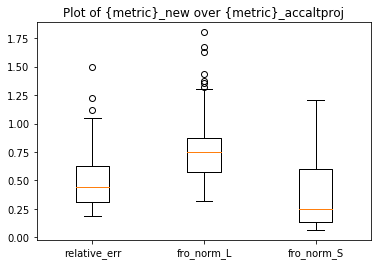

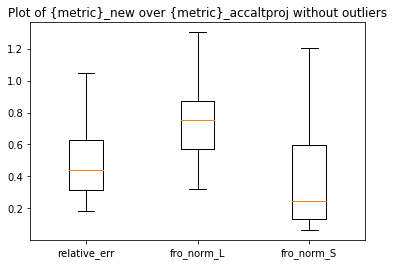

relative_err: 3/120 outliers
fro_norm_L: 7/120 outliers
fro_norm_S: 0/120 outliers


In [26]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err, \
     "fro_norm_L": fro_norm_L \
    , "fro_norm_S": fro_norm_S \
    #, "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
# plt.savefig('plots/p1.7.eps', format='eps')
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

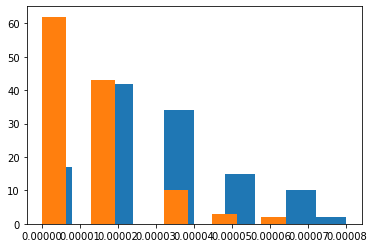

In [27]:
plt.hist(count_nonzeros_S_accaltproj)
plt.hist(count_nonzeros_S_new)
# plt.savefig('plots/p1.8.eps', format='eps')
plt.show()

In [28]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.1715844068790986e-43
fro_norm_L:  5.257257827527669e-14
fro_norm_S:  2.0058454391122148e-42


In [29]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new), np.max(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj), np.max(count_nonzeros_S_accaltproj))

0.0 1.0666667e-05 6.4e-05
3.2e-05 2.7333335e-05 8e-05


### Scenario 2:
**alpha = 0.3** (higher sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=7.433e-01,; beta=5.649e-02

In [30]:
## ======================== 0. set constants ========================
#d1 = 250                   # num. of rows
#d2 = 250                   # num. of columns
#max_iter = 100              # num. of layers trained
alpha_true = 0.3
c_true = 1
#r = 2
#dataset_size = 300

## ======================== 1. generate data ========================
train2, test2 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [31]:
## ======================== 2. estimations by classical ========================
train_est2 = []
for i, (L_true, S_true, M_true) in enumerate(train2):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est2.append((L0, S0, M_true))

In [34]:
## ======================== 3. train unrolled network with estimated data ========================
net2, params_bftrain2, params_aftrain2, l0_norm_of_S_Shat2 = train_nn(LearnedAAP(max_iter, d1, d2), r \
                                                                    , lr=7e-03, weight_decay=0 \
                                                                    , nepochs=8, dataset=train_est2)

[Parameter containing:
tensor(7.003e-01, requires_grad=True), Parameter containing:
tensor(3.177e-02, dtype=torch.float64, requires_grad=True)]
tensor(-3.977e-10) tensor(-2.083e-10, dtype=torch.float64)
Epoch 1/8 at cost=1.438554050187113e-11
[Parameter containing:
tensor(7.005e-01, requires_grad=True), Parameter containing:
tensor(3.189e-02, dtype=torch.float64, requires_grad=True)]
tensor(-3.017e-10) tensor(-1.508e-10, dtype=torch.float64)
Epoch 1/8 at cost=2.6261137361927034e-11
[Parameter containing:
tensor(7.009e-01, requires_grad=True), Parameter containing:
tensor(3.212e-02, dtype=torch.float64, requires_grad=True)]
tensor(-1.262e-09) tensor(-6.126e-10, dtype=torch.float64)
Epoch 1/8 at cost=1.6462890078949854e-11
[Parameter containing:
tensor(7.015e-01, requires_grad=True), Parameter containing:
tensor(3.239e-02, dtype=torch.float64, requires_grad=True)]
tensor(-1.143e-09) tensor(-5.556e-10, dtype=torch.float64)
Epoch 1/8 at cost=1.0841761516333648e-11
[Parameter containing:
te

#### Evaluating unrolled network on train dataset

In [35]:
out_bftrain2, out_hat2 = get_net_outputs(net2, LearnedAAP(max_iter, d1, d2), r, train2)
out_accaltproj2 = []
for i, (L_true, S_true, M_true) in enumerate(train2):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj2.append((L0, S0))

/Users/elitanzc/Github/Unrolled_AccAltProj/helper.py:226: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/Unrolled_AccAltProj/helper.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


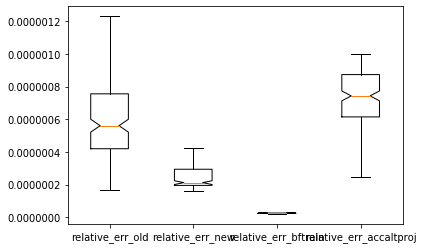

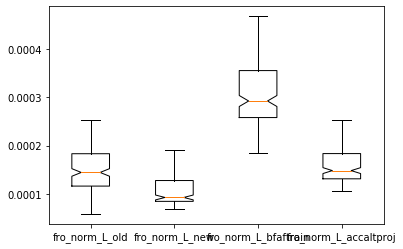

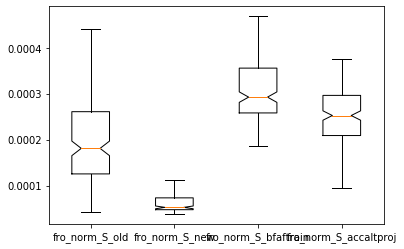

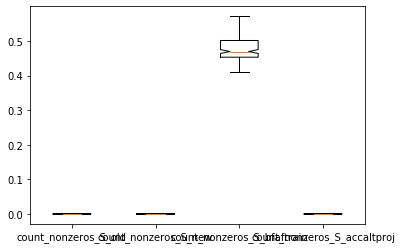

In [36]:
metrics = get_metrics(train2, [x[:2] for x in train_est2], out_bftrain2, out_hat2)
fro_norm_L_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train2, out_accaltproj2, out_bftrain2, out_hat2).values())[:4]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [38]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  8.261729963129672e-39
fro_norm_L_new, fro_norm_L_old:  0.031124027876652128
fro_norm_S_new, fro_norm_S_old:  0.030441042419176823
count_nonzeros_S_new, count_nonzeros_S_old:  0.0003070600868354043

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  2.5360780438044924e-84
fro_norm_L_new, fro_norm_L_accaltproj:  2.3141778191519473e-23
fro_norm_S_new, fro_norm_S_accaltproj:  1.4698225809952494e-89
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.367811708612973e-47

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  1.70211055721904e-55
fro_norm_S_new, fro_norm_S_bftrain:  5.3321904898136385e-70
count_nonzeros_S_new, count_nonzeros_S_bftrain:  8.679766802278673e-193


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/3710792896.py:4: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/3710792896.py:4: RuntimeWarning: divide by zero encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])


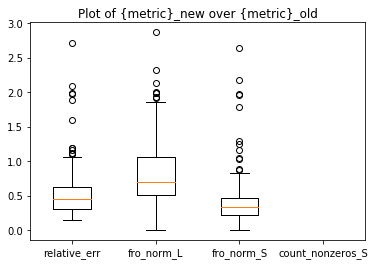

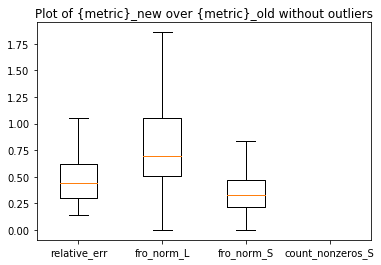

relative_err: 12/180 outliers
fro_norm_L: 8/180 outliers
fro_norm_S: 12/180 outliers
count_nonzeros_S: 0/180 outliers


In [39]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

(array([165.,   8.,   5.,   0.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([0.000e+00, 2.240e-05, 4.480e-05, 6.720e-05, 8.960e-05, 1.120e-04,
        1.344e-04, 1.568e-04, 1.792e-04, 2.016e-04, 2.240e-04],
       dtype=float32),
 <a list of 10 Patch objects>)

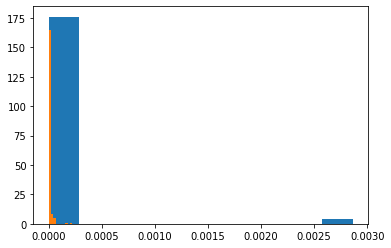

In [40]:
plt.hist(count_nonzeros_S_old)
plt.hist(count_nonzeros_S_new)

In [41]:
print("P-values from test of mean with H1: _new/_old < 1")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  6.778950106579023e-40
fro_norm_L:  1.2708031763889377e-07
fro_norm_S:  1.0631735957946999e-50
count_nonzeros_S:  nan


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/3711251554.py:4: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])


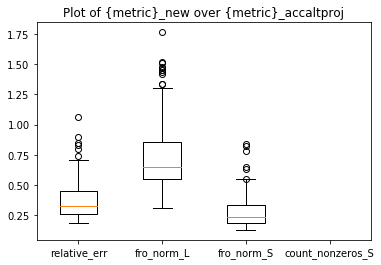

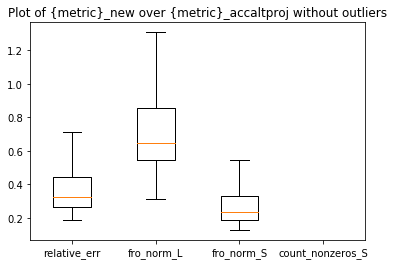

relative_err: 6/180 outliers
fro_norm_L: 11/180 outliers
fro_norm_S: 6/180 outliers
count_nonzeros_S: 0/180 outliers


In [42]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [43]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  6.006606509550401e-114
fro_norm_L:  1.3647124891711966e-24
fro_norm_S:  1.5901941453431317e-138
count_nonzeros_S:  nan


In [44]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new), np.max(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj), np.max(count_nonzeros_S_accaltproj))
print(np.median(count_nonzeros_S_old), np.mean(count_nonzeros_S_old), np.max(count_nonzeros_S_old))

0.0 8.533334e-06 0.000224
6.4e-05 6.2577776e-05 0.000144
4.8e-05 0.00011075555 0.002864


#### Evaluating unrolled network on test dataset

In [45]:
out_bftrain_ontest2, out_hat_ontest2 = get_net_outputs(net2, LearnedAAP(max_iter, d1, d2), r, test2)
out_accaltproj_ontest2 = []
out_ircur_ontest2 = []
for (L_true, S_true, M_true) in test2:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj_ontest2.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    out_ircur_ontest2.append((L0, S0))

/Users/elitanzc/Github/Unrolled_AccAltProj/helper.py:226: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/Unrolled_AccAltProj/helper.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


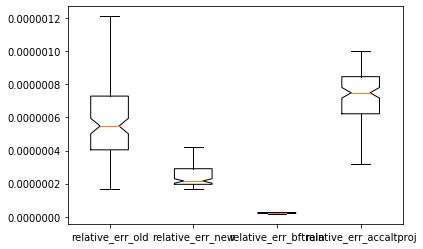

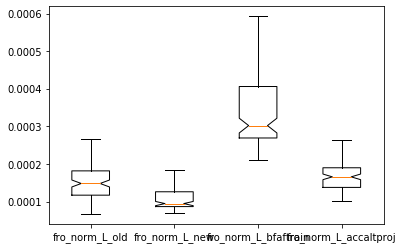

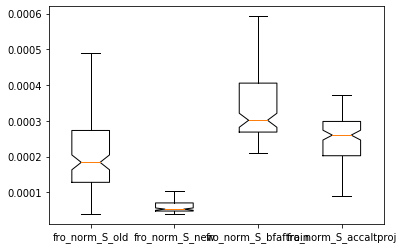

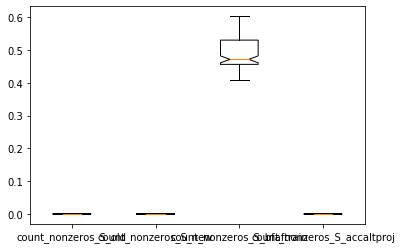

In [46]:
metrics = get_metrics(test2, out_ircur_ontest2, out_bftrain_ontest2, out_hat_ontest2)
fro_norm_L_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test2, out_accaltproj_ontest2, out_bftrain_ontest2, out_hat_ontest2).values())[:4]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
# plt.savefig('plots/p2.1.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
# plt.savefig('plots/p2.2.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
# plt.savefig('plots/p2.3.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
# plt.savefig('plots/p2.4.eps', format='eps')
plt.show()

In [47]:
for arr in [
    relative_err_old, fro_norm_L_old, fro_norm_S_old, count_nonzeros_S_old,
    relative_err_accaltproj, fro_norm_L_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj,
    relative_err_new, fro_norm_L_new, fro_norm_S_new, count_nonzeros_S_new
]:
    print(f'median={np.median(arr)}, iqr={np.quantile(arr, 0.75) - np.quantile(arr, 0.25)}', f'mean={np.mean(arr)}, std={np.std(arr, ddof=1)}')

median=5.476802016346483e-07, iqr=3.238752768197628e-07 mean=6.127742153694271e-07, std=3.1055472504704085e-07
median=0.00014796381583437324, iqr=6.460261101892684e-05 mean=0.02392381802201271, std=0.15754434466362
median=0.00018419692059978843, iqr=0.00014504889986710623 mean=0.02397751435637474, std=0.15753677487373352
median=4.8000001697801054e-05, iqr=5.199999804972322e-05 mean=0.0001170666582765989, std=0.000425398611696437
median=7.481299917344586e-07, iqr=2.2383039777196245e-07 mean=7.302609219550504e-07, std=1.5908585737633985e-07
median=0.00016560213407501578, iqr=5.223344123805873e-05 mean=0.00016744348977226764, std=3.652878149296157e-05
median=0.0002603652246762067, iqr=9.589065302861854e-05 mean=0.00024878408294171095, std=6.623783701797947e-05
median=6.399999983841553e-05, iqr=4.7999998059822246e-05 mean=5.746667011408135e-05, std=2.847819087037351e-05
median=2.1648706649557425e-07, iqr=9.419192537052368e-08 mean=2.562179304277379e-07, std=8.988541111421e-08
median=9.4526

In [48]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  2.8663141152563206e-23
fro_norm_L_new, fro_norm_L_old:  0.05020906425451322
fro_norm_S_new, fro_norm_S_old:  0.04948246386847196
count_nonzeros_S_new, count_nonzeros_S_old:  0.0025528881159266555

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.4606378504869293e-56
fro_norm_L_new, fro_norm_L_accaltproj:  1.971525729121094e-20
fro_norm_S_new, fro_norm_S_accaltproj:  8.934995939252954e-58
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  5.793045632788096e-45

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  3.600693631045574e-34
fro_norm_S_new, fro_norm_S_bftrain:  4.0906432894483465e-41
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.8184585733034403e-121


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/1458627944.py:4: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])


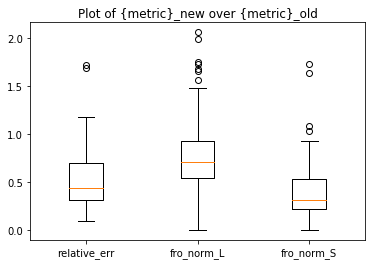

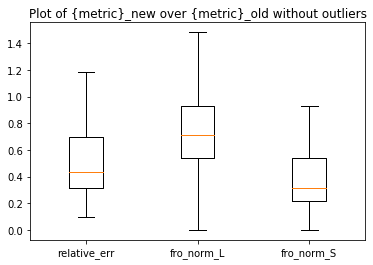

relative_err: 2/120 outliers
fro_norm_L: 7/120 outliers
fro_norm_S: 4/120 outliers


In [49]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "fro_norm_S": fro_norm_S \
    #, "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
# plt.savefig('plots/p2.5.eps', format='eps')
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

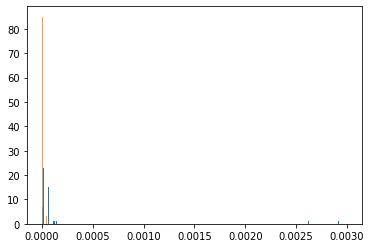

In [50]:
_, bins, _ = plt.hist(count_nonzeros_S_new)
plt.clf()
plt.hist(count_nonzeros_S_old, bins=np.arange(0, 0.003, 6.40e-06))
plt.hist(count_nonzeros_S_new, alpha=0.8)
# plt.savefig('plots/p2.6.eps', format='eps')
plt.show()

In [51]:
print("P-values from test of mean with H1: _new/_old < 1")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  1.4076805984451597e-36
fro_norm_L:  9.296709622419691e-10
fro_norm_S:  2.8130182879037617e-45


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/1216122920.py:4: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])


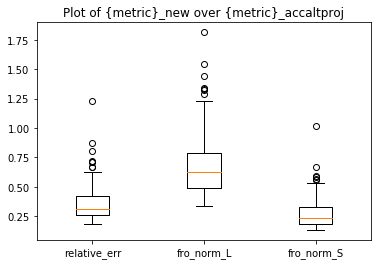

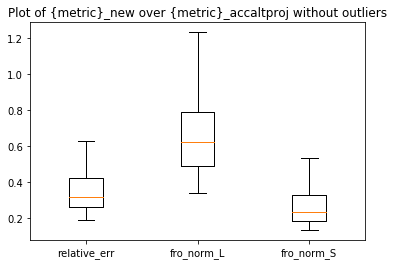

relative_err: 8/120 outliers
fro_norm_L: 7/120 outliers
fro_norm_S: 6/120 outliers


In [52]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "fro_norm_S": fro_norm_S \
    #, "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
# plt.savefig('plots/p2.7.eps', format='eps')
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

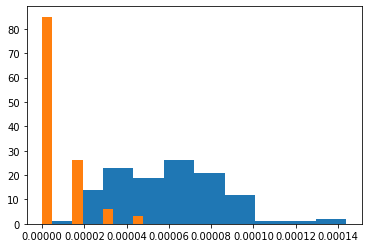

In [53]:
plt.hist(count_nonzeros_S_accaltproj)
plt.hist(count_nonzeros_S_new)
# plt.savefig('plots/p2.8.eps', format='eps')
plt.show()

In [54]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.1444633467722164e-73
fro_norm_L:  9.719984216516015e-21
fro_norm_S:  1.2461570932025535e-90


In [55]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new), np.max(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj), np.max(count_nonzeros_S_accaltproj))
print(np.median(count_nonzeros_S_old), np.mean(count_nonzeros_S_old), np.max(count_nonzeros_S_old))

0.0 6.266667e-06 4.8e-05
6.4e-05 5.746667e-05 0.000144
4.8e-05 0.00011706666 0.002912


### Scenario 3:
**alpha = 0.01** (lower sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=7.195e-01; beta=1.112e-01

*** ***

In [56]:
## ======================== 0. set constants ========================
# d1 = 250                   # num. of rows
# d2 = 250                   # num. of columns
# max_iter = 100              # num. of layers trained
alpha_true = 0.01
c_true = 1
# r = 2
# dataset_size = 300

## ======================== 1. generate data ========================
train3, test3 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [57]:
## ======================== 2. estimations by classical ========================
train_est3 = []
for i, (L_true, S_true, M_true) in enumerate(train3):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est3.append((L0, S0, M_true))

In [58]:
1/(2 * np.power(250 * 250, 1/4))

0.03162277660168379

In [61]:
## ======================== 3. train unrolled network with estimated data ========================
net3, params_bftrain3, params_aftrain3, l0_norm_of_S_Shat3 = train_nn(LearnedAAP(max_iter, d1, d2), r \
                                                                    , lr=2e-03, weight_decay=0 \
                                                                    , nepochs=8, dataset=train_est3)

[Parameter containing:
tensor(7.006e-01, requires_grad=True), Parameter containing:
tensor(3.200e-02, dtype=torch.float64, requires_grad=True)]
tensor(-4.649e-09) tensor(-2.351e-09, dtype=torch.float64)
Epoch 1/8 at cost=1.8432972481718934e-08
[Parameter containing:
tensor(7.018e-01, requires_grad=True), Parameter containing:
tensor(3.291e-02, dtype=torch.float64, requires_grad=True)]
tensor(-3.192e-08) tensor(-1.662e-08, dtype=torch.float64)
Epoch 1/8 at cost=3.4691402528430615e-10
[Parameter containing:
tensor(7.028e-01, requires_grad=True), Parameter containing:
tensor(3.363e-02, dtype=torch.float64, requires_grad=True)]
tensor(-5.572e-09) tensor(-2.572e-09, dtype=torch.float64)
Epoch 1/8 at cost=1.2775239754958534e-09
[Parameter containing:
tensor(7.036e-01, requires_grad=True), Parameter containing:
tensor(3.425e-02, dtype=torch.float64, requires_grad=True)]
tensor(-4.143e-09) tensor(-2.279e-09, dtype=torch.float64)
Epoch 1/8 at cost=2.2087467965725693e-10
[Parameter containing:
t

#### Evaluating unrolled network on train dataset

In [62]:
out_bftrain3, out_hat3 = get_net_outputs(net3, LearnedAAP(max_iter, d1, d2), r, train3)
out_accaltproj3 = []
for i, (L_true, S_true, M_true) in enumerate(train3):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj3.append((L0, S0))

/Users/elitanzc/Github/Unrolled_AccAltProj/helper.py:226: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/Unrolled_AccAltProj/helper.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


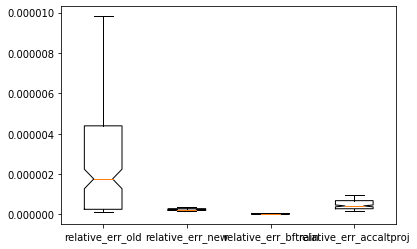

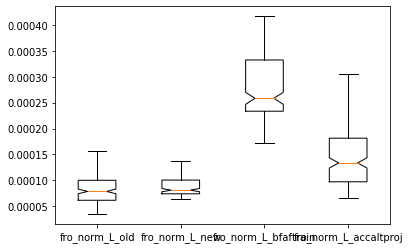

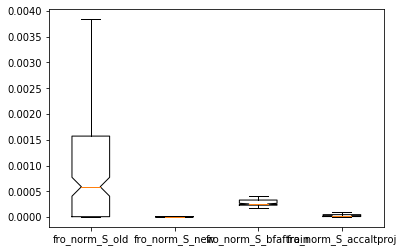

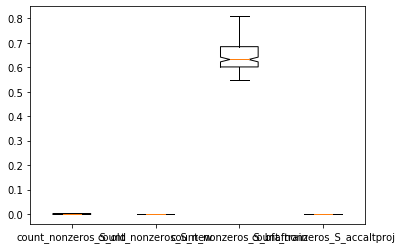

In [63]:
metrics = get_metrics(train3, [x[:2] for x in train_est3], out_bftrain3, out_hat3)
fro_norm_L_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train3, out_accaltproj3, out_bftrain3, out_hat3).values())[:4]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [64]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  3.9376092119417477e-19
fro_norm_L_new, fro_norm_L_old:  0.8879056852002539
fro_norm_S_new, fro_norm_S_old:  3.603484628520312e-20
count_nonzeros_S_new, count_nonzeros_S_old:  5.516697146386828e-33

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.3947845427154107e-28
fro_norm_L_new, fro_norm_L_accaltproj:  1.808720172122136e-21
fro_norm_S_new, fro_norm_S_accaltproj:  3.6474560260285014e-13
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  4.883209774219225e-10

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  3.373343881203776e-53
fro_norm_S_new, fro_norm_S_bftrain:  1.9347975671870576e-70
count_nonzeros_S_new, count_nonzeros_S_bftrain:  2.650819450196025e-174


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/3710792896.py:4: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])


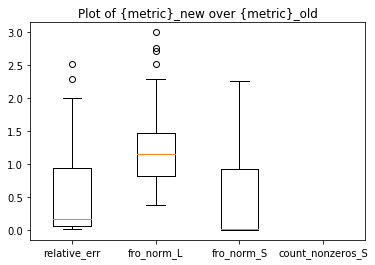

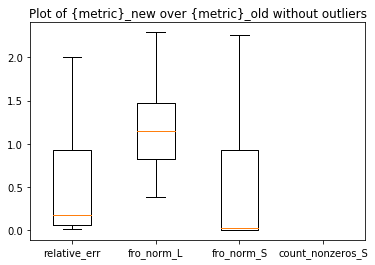

relative_err: 2/180 outliers
fro_norm_L: 4/180 outliers
fro_norm_S: 0/180 outliers
count_nonzeros_S: 0/180 outliers


In [65]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [66]:
print("P-values from test of mean with H1: _new/_old < 1")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  4.676639386389693e-22
fro_norm_L:  0.9999997650193041
fro_norm_S:  7.091875091490336e-27
count_nonzeros_S:  nan


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/3711251554.py:4: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])


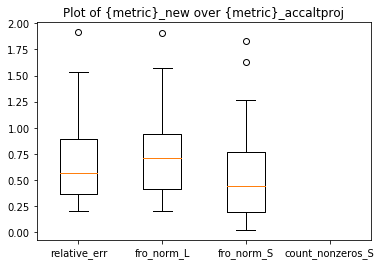

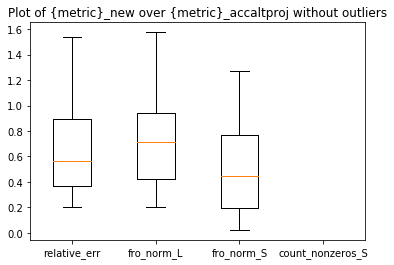

relative_err: 1/180 outliers
fro_norm_L: 1/180 outliers
fro_norm_S: 2/180 outliers
count_nonzeros_S: 0/180 outliers


In [67]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [68]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  2.5256287119789776e-32
fro_norm_L:  1.4717537711874889e-24
fro_norm_S:  1.8713717621189553e-44
count_nonzeros_S:  nan


In [69]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new), np.max(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj), np.max(count_nonzeros_S_accaltproj))
print(np.median(count_nonzeros_S_old), np.mean(count_nonzeros_S_old), np.max(count_nonzeros_S_old))

0.0 8.8888885e-07 3.2e-05
0.0 3.911111e-06 3.2e-05
1.6e-05 1.7333334e-05 8e-05


#### Evaluating unrolled network on test dataset

In [70]:
out_bftrain_ontest3, out_hat_ontest3 = get_net_outputs(net3, LearnedAAP(max_iter, d1, d2), r, test3)
out_accaltproj_ontest3 = []
out_ircur_ontest3 = []
for (L_true, S_true, M_true) in test3:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj_ontest3.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    out_ircur_ontest3.append((L0, S0))

/Users/elitanzc/Github/Unrolled_AccAltProj/helper.py:226: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/Unrolled_AccAltProj/helper.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


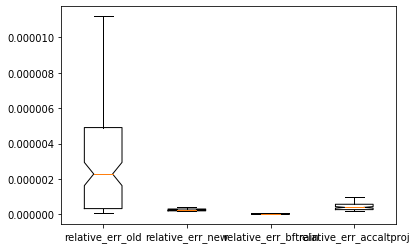

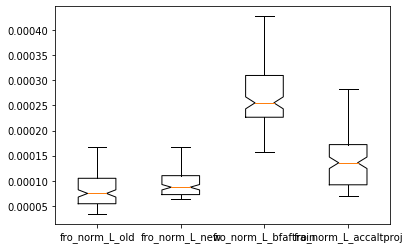

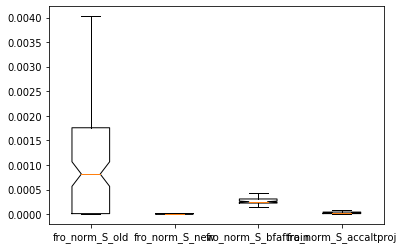

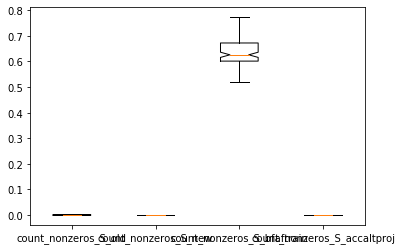

In [71]:
metrics = get_metrics(test3, out_ircur_ontest3, out_bftrain_ontest3, out_hat_ontest3)
fro_norm_L_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test3, out_accaltproj_ontest3, out_bftrain_ontest3, out_hat_ontest3).values())[:4]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
# plt.savefig('plots/p3.1.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
# plt.savefig('plots/p3.2.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
# plt.savefig('plots/p3.3.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
# plt.savefig('plots/p3.4.eps', format='eps')
plt.show()

In [72]:
for arr in [
    relative_err_old, fro_norm_L_old, fro_norm_S_old, count_nonzeros_S_old,
    relative_err_accaltproj, fro_norm_L_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj,
    relative_err_new, fro_norm_L_new, fro_norm_S_new, count_nonzeros_S_new
]:
    print(f'median={np.median(arr)}, iqr={np.quantile(arr, 0.75) - np.quantile(arr, 0.25)}', f'mean={np.mean(arr)}, std={np.std(arr, ddof=1)}')

median=2.286324161104858e-06, iqr=4.57678354592872e-06 mean=3.716700803124695e-06, std=4.791685569216497e-06
median=7.504643872380257e-05, iqr=5.0587606892804615e-05 mean=8.152044756570831e-05, std=3.201778599759564e-05
median=0.0008162714075297117, iqr=0.0017466181659528957 mean=0.0012902045855298638, std=0.001687604351900518
median=1.5999999959603883e-05, iqr=3.199999991920777e-05 mean=2.119999953720253e-05, std=2.177099850086961e-05
median=4.0079558516481484e-07, iqr=3.026838442110602e-07 mean=4.563413540381589e-07, std=2.1227462809747522e-07
median=0.00013599010708276182, iqr=7.994984662218485e-05 mean=0.00014885108976159245, std=6.606295210076496e-05
median=1.998296102101449e-05, iqr=3.1440965585716185e-05 mean=4.658192119677551e-05, std=6.679291982436553e-05
median=0.0, iqr=0.0 mean=3.066666749873548e-06, std=6.655677225353429e-06
median=2.492758994776523e-07, iqr=1.0406565209564178e-07 mean=2.6979867584486783e-07, std=7.498927345750417e-08
median=8.738970791455358e-05, iqr=3.765

In [73]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  8.115140304069892e-13
fro_norm_L_new, fro_norm_L_old:  0.9996342014694958
fro_norm_S_new, fro_norm_S_old:  9.586062129296746e-14
count_nonzeros_S_new, count_nonzeros_S_old:  9.80634030404198e-19

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  9.2297181712477e-16
fro_norm_L_new, fro_norm_L_accaltproj:  1.368737045050837e-14
fro_norm_S_new, fro_norm_S_accaltproj:  1.1142879815545441e-07
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  5.520712667987143e-05

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  3.385308398114913e-37
fro_norm_S_new, fro_norm_S_bftrain:  1.278860023624159e-52
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.289766882491224e-122


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/3082108843.py:4: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])


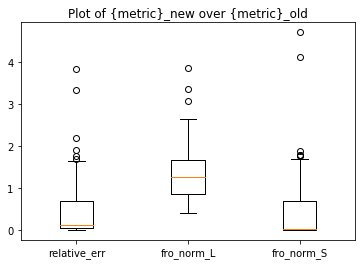

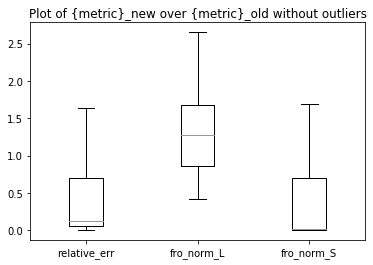

relative_err: 6/120 outliers
fro_norm_L: 3/120 outliers
fro_norm_S: 6/120 outliers


In [74]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "fro_norm_S": fro_norm_S \
    #, "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
# plt.savefig('plots/p3.5.eps', format='eps')
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

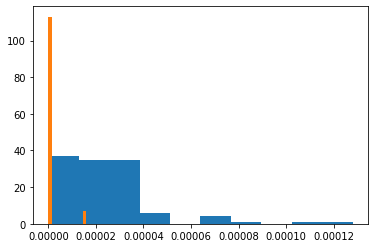

In [76]:
plt.hist(count_nonzeros_S_old)
plt.hist(count_nonzeros_S_new)
# plt.savefig('plots/p3.6.eps', format='eps')
plt.show()

In [77]:
print("P-values from test of mean with H1: _new/_old < 1")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  8.905237486892503e-15
fro_norm_L:  0.9999999898754504
fro_norm_S:  5.656847254298812e-14


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/638283807.py:4: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])


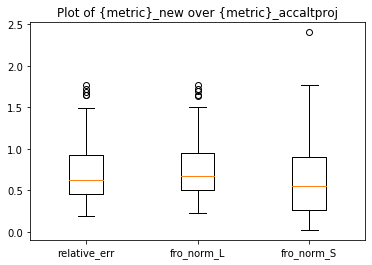

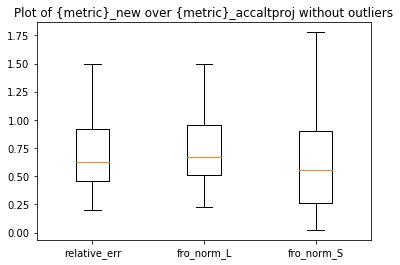

relative_err: 5/120 outliers
fro_norm_L: 5/120 outliers
fro_norm_S: 1/120 outliers


In [78]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "fro_norm_S": fro_norm_S \
    #, "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
# plt.savefig('plots/p3.7.eps', format='eps')
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

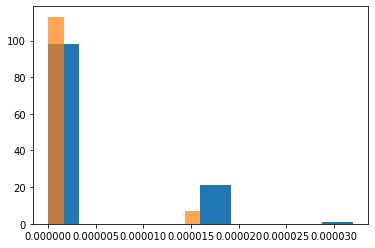

In [79]:
plt.hist(count_nonzeros_S_accaltproj)
plt.hist(count_nonzeros_S_new, alpha=0.7)
# plt.savefig('plots/p3.8.eps', format='eps')
plt.show()

In [80]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0623549523439305e-14
fro_norm_L:  3.714037050331936e-13
fro_norm_S:  7.399638904583305e-20


In [81]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new), np.max(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj), np.max(count_nonzeros_S_accaltproj))
print(np.median(count_nonzeros_S_old), np.mean(count_nonzeros_S_old), np.max(count_nonzeros_S_old))

0.0 9.333333e-07 1.6e-05
0.0 3.0666667e-06 3.2e-05
1.6e-05 2.12e-05 0.000128


### Scenario 4:
**alpha = 0.1** (higher sparsity), **c = 10**, r = 2, dimension = 250x250

gamma=7.359e-01; beta=4.489e-02

*** ***

In [82]:
## ======================== 0. set constants ========================
# d1 = 250                   # num. of rows
# d2 = 250                   # num. of columns
# max_iter = 100              # num. of layers trained
alpha_true = 0.1
c_true = 10
# r = 2
# dataset_size = 300

## ======================== 1. generate data ========================
train4, test4 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [83]:
## ======================== 2. estimations by classical ========================
train_est4 = []
for i, (L_true, S_true, M_true) in enumerate(train4):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est4.append((L0, S0, M_true))

In [84]:
## ======================== 3. train unrolled network with estimated data ========================
net4, params_bftrain4, params_aftrain4, l0_norm_of_S_Shat4 = train_nn(LearnedAAP(max_iter, d1, d2), r \
                                                                    , lr=4e-02, weight_decay=0 \
                                                                    , nepochs=8, dataset=train_est4)

[Parameter containing:
tensor(7.001e-01, requires_grad=True), Parameter containing:
tensor(3.166e-02, dtype=torch.float64, requires_grad=True)]
tensor(-1.678e-11) tensor(-8.375e-12, dtype=torch.float64)
Epoch 1/8 at cost=6.61874157911746e-12
[Parameter containing:
tensor(7.002e-01, requires_grad=True), Parameter containing:
tensor(3.175e-02, dtype=torch.float64, requires_grad=True)]
tensor(-7.057e-11) tensor(-3.499e-11, dtype=torch.float64)
Epoch 1/8 at cost=3.169084439313963e-11
[Parameter containing:
tensor(7.004e-01, requires_grad=True), Parameter containing:
tensor(3.182e-02, dtype=torch.float64, requires_grad=True)]
tensor(-2.161e-11) tensor(-1.078e-11, dtype=torch.float64)
Epoch 1/8 at cost=7.444826005675864e-12
[Parameter containing:
tensor(7.007e-01, requires_grad=True), Parameter containing:
tensor(3.201e-02, dtype=torch.float64, requires_grad=True)]
tensor(-1.993e-10) tensor(-1.189e-10, dtype=torch.float64)
Epoch 1/8 at cost=1.7831088168496212e-12
[Parameter containing:
tenso

#### Evaluating unrolled network on train dataset

In [85]:
out_bftrain4, out_hat4 = get_net_outputs(net4, LearnedAAP(max_iter, d1, d2), r, train4)
out_accaltproj4 = []
for i, (L_true, S_true, M_true) in enumerate(train4):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj4.append((L0, S0))

/Users/elitanzc/Github/Unrolled_AccAltProj/helper.py:226: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/Unrolled_AccAltProj/helper.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


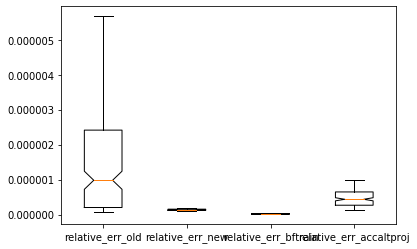

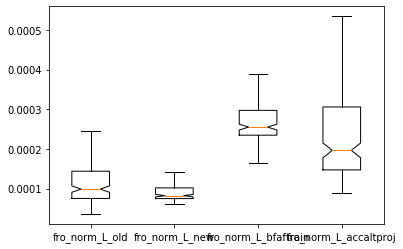

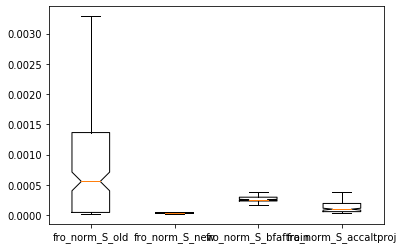

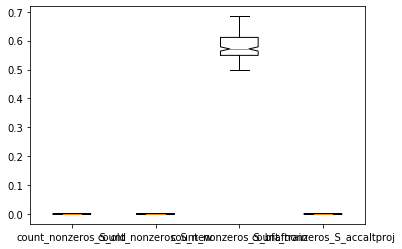

In [86]:
metrics = get_metrics(train4, [x[:2] for x in train_est4], out_bftrain4, out_hat4)
fro_norm_L_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train4, out_accaltproj4, out_bftrain4, out_hat4).values())[:4]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, \
    relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", \
    "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [87]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  6.132002749160809e-20
fro_norm_L_new, fro_norm_L_old:  3.96097184448785e-06
fro_norm_S_new, fro_norm_S_old:  3.469419659920569e-20
count_nonzeros_S_new, count_nonzeros_S_old:  0.9999999999999879

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.2539890994916002e-43
fro_norm_L_new, fro_norm_L_accaltproj:  2.3517121191591097e-34
fro_norm_S_new, fro_norm_S_accaltproj:  1.370476561306282e-20
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  0.9999999999999922

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  3.687522675559913e-50
fro_norm_S_new, fro_norm_S_bftrain:  1.462242816271372e-62
count_nonzeros_S_new, count_nonzeros_S_bftrain:  9.818321136561659e-180


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/3009456309.py:4: RuntimeWarning: divide by zero encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])


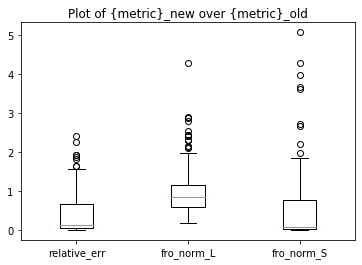

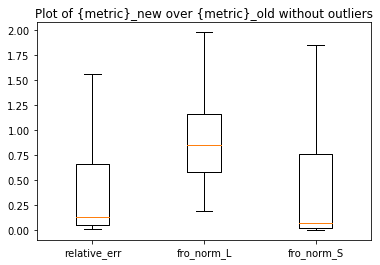

relative_err: 8/180 outliers
fro_norm_L: 14/180 outliers
fro_norm_S: 9/180 outliers


In [89]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "fro_norm_S": fro_norm_S \
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [90]:
print("P-values from test of mean with H1: _new/_old < 1")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  1.523213236075988e-33
fro_norm_L:  0.5026551122052955
fro_norm_S:  2.2850675547948343e-13


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/4068723786.py:4: RuntimeWarning: divide by zero encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])


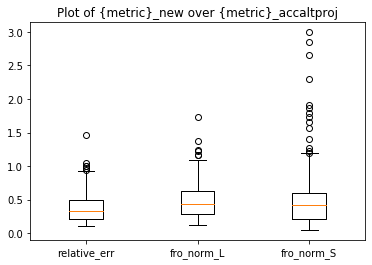

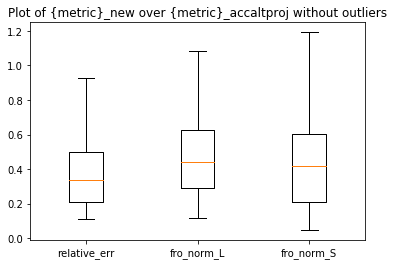

relative_err: 6/180 outliers
fro_norm_L: 6/180 outliers
fro_norm_S: 14/180 outliers


In [92]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "fro_norm_S": fro_norm_S \
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [93]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.4439738068330667e-82
fro_norm_L:  3.4617374852805875e-60
fro_norm_S:  5.160405456030799e-28


In [94]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new), np.max(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj), np.max(count_nonzeros_S_accaltproj))
print(np.median(count_nonzeros_S_old), np.mean(count_nonzeros_S_old), np.max(count_nonzeros_S_old))

0.000416 0.0014264889 0.012096
0.0 5.688889e-06 4.8e-05
1.6e-05 1.7244445e-05 8e-05


#### Evaluating unrolled network on test dataset

In [95]:
out_bftrain_ontest4, out_hat_ontest4 = get_net_outputs(net4, LearnedAAP(max_iter, d1, d2), r, test4)
out_accaltproj_ontest4 = []
out_ircur_ontest4 = []
for (L_true, S_true, M_true) in test4:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj_ontest4.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    out_ircur_ontest4.append((L0, S0))

/Users/elitanzc/Github/Unrolled_AccAltProj/helper.py:226: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/Unrolled_AccAltProj/helper.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


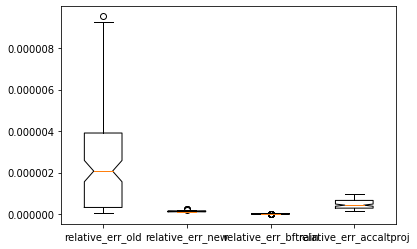

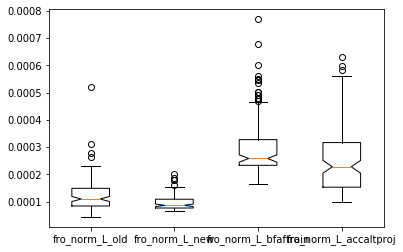

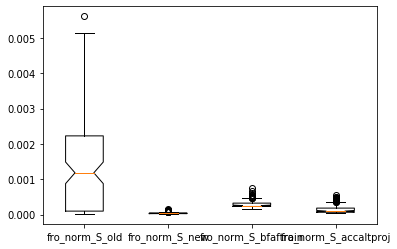

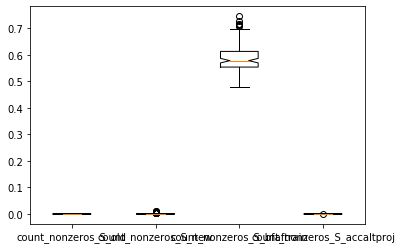

In [97]:
metrics = get_metrics(test4, out_ircur_ontest4, out_bftrain_ontest4, out_hat_ontest4)
fro_norm_L_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test4, out_accaltproj_ontest4, out_bftrain_ontest4, out_hat_ontest4).values())[:4]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
# plt.savefig('plots/p4.1.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
# plt.savefig('plots/p4.2.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
# plt.savefig('plots/p4.3.eps', format='eps')
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
# plt.savefig('plots/p4.4.eps', format='eps')
plt.show()

In [99]:
for arr in [
    relative_err_old, fro_norm_L_old, fro_norm_S_old, count_nonzeros_S_old,
    relative_err_accaltproj, fro_norm_L_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj,
    relative_err_new, fro_norm_L_new, fro_norm_S_new, count_nonzeros_S_new
]:
    print(f'median={np.median(arr)}, iqr={np.quantile(arr, 0.75) - np.quantile(arr, 0.25)}', f'mean={np.mean(arr)}, std={np.std(arr, ddof=1)}')

median=2.0765623958141077e-06, iqr=3.5792026977787827e-06 mean=2.490672841304331e-06, std=2.3696613880019868e-06
median=0.00010920742352027446, iqr=6.48244094918482e-05 mean=0.0001223846775246784, std=6.231114093679935e-05
median=0.001184686436317861, iqr=0.0021282450143189635 mean=0.0014195702970027924, std=0.001395513187162578
median=1.5999999959603883e-05, iqr=3.199999991920777e-05 mean=2.2133335733087733e-05, std=1.9031567717320286e-05
median=4.3973335550617776e-07, iqr=3.717924457191657e-07 mean=4.889071192337724e-07, std=2.2758109707865515e-07
median=0.00022741022985428572, iqr=0.00016366327690775506 mean=0.00025057056336663663, std=0.0001165802386822179
median=0.00010236134403385222, iqr=0.00011785730384872295 mean=0.00015578475722577423, std=0.0001305687619606033
median=0.0, iqr=1.5999999959603883e-05 mean=4.933333002554718e-06, std=8.750254892220255e-06
median=1.336813681973581e-07, iqr=4.168000344861866e-08 mean=1.4594776587273373e-07, std=3.266994852424432e-08
median=8.59517

In [100]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0054316362545148e-19
fro_norm_L_new, fro_norm_L_old:  1.4412895800276973e-05
fro_norm_S_new, fro_norm_S_old:  1.4398427300868255e-19
count_nonzeros_S_new, count_nonzeros_S_old:  0.9999999999343624

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  2.0144418399020807e-32
fro_norm_L_new, fro_norm_L_accaltproj:  9.626725142144106e-28
fro_norm_S_new, fro_norm_S_accaltproj:  1.9031180124170205e-15
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  0.9999999999570122

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  8.745057666353834e-41
fro_norm_S_new, fro_norm_S_bftrain:  3.2298496278620937e-50
count_nonzeros_S_new, count_nonzeros_S_bftrain:  2.68711129633579e-125


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/3492296540.py:4: RuntimeWarning: divide by zero encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])


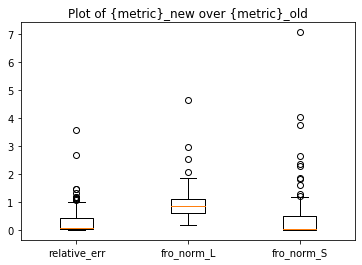

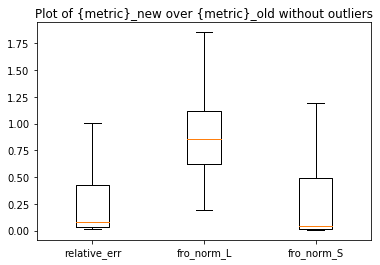

relative_err: 12/120 outliers
fro_norm_L: 4/120 outliers
fro_norm_S: 11/120 outliers


In [101]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "fro_norm_S": fro_norm_S \
    #, "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
# plt.savefig('plots/p4.5.eps', format='eps')
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

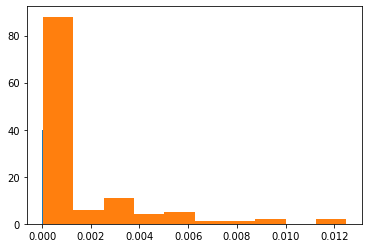

In [102]:
plt.hist(count_nonzeros_S_new, color='tab:orange')
plt.hist(count_nonzeros_S_old, color='tab:blue')
# plt.savefig('plots/p4.6.eps', format='eps')
plt.show()

In [103]:
print("P-values from test of mean with H1: _new/_old < 1")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  4.316818308059162e-27
fro_norm_L:  0.14838980991172995
fro_norm_S:  3.8462625432554796e-10


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_83141/1543297600.py:4: RuntimeWarning: divide by zero encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])


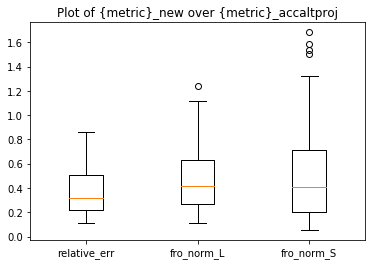

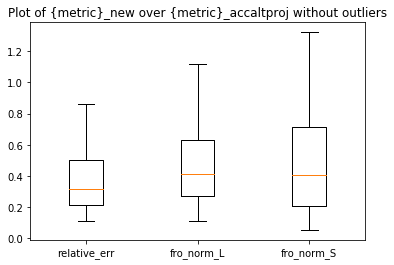

relative_err: 0/120 outliers
fro_norm_L: 1/120 outliers
fro_norm_S: 4/120 outliers


In [104]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "fro_norm_S": fro_norm_S \
    #, "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
# plt.savefig('plots/p4.7.eps', format='eps')
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

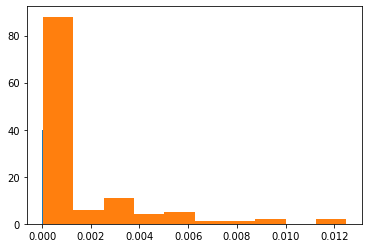

In [105]:
plt.hist(count_nonzeros_S_new, color='tab:orange')
plt.hist(count_nonzeros_S_old, color='tab:blue')
# plt.savefig('plots/p4.8.eps', format='eps')
plt.show()

In [106]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  5.873617197526244e-65
fro_norm_L:  7.67932291739309e-51
fro_norm_S:  8.007067408908984e-30


In [107]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new), np.max(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj), np.max(count_nonzeros_S_accaltproj))
print(np.median(count_nonzeros_S_old), np.mean(count_nonzeros_S_old), np.max(count_nonzeros_S_old))

0.000488 0.0015432 0.012496
0.0 4.933333e-06 4.8e-05
1.6e-05 2.2133336e-05 8e-05
